In [101]:
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import seaborn as sb
sb.set()


sp = spotipy.Spotify()

#tok = util.prompt_for_user_token(client_id=cid, client_secret=csec)
        
cid = "34f843c5f22c4242a2647ec4651ba2ce"
csec = "0826e491d90f4e43bbaec2fee7534610"


client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=csec)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlists = sp.user_playlists('1279914484')

while playlists:
    for i, playlist in enumerate(playlists['items']):
        print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None



   1 spotify:user:1279914484:playlist:7iasGlft8RiAfg0YVkJAgQ shit hits
   2 spotify:user:1279914484:playlist:3E33JN7dyIf6cZ0YavjYZp yuh
   3 spotify:user:1279914484:playlist:3rtLzJWLTVxeG5iWWVFvgg 💨
   4 spotify:user:1279914484:playlist:0S4TYq34iAGiofq4LsIsaO lift 💪🏾😤
   5 spotify:user:1279914484:playlist:2s8wI6QXPVOLAkWlHvJhh8 mhm
   6 spotify:user:1279914484:playlist:1lMrfC4XFYffbjsvLNNnDs study beatz
   7 spotify:user:1279914484:playlist:3XpZeTPNqckiIAMqnzZFYH rocky, my father
   8 spotify:user:1279914484:playlist:6gewXox7Bs8QaXrMe7hQQs run 🏃🏾‍♀️
   9 spotify:user:1279914484:playlist:7kTLFl0CdxgVqCy9GyHRml desi ting$
  10 spotify:user:1279914484:playlist:2sHL2EHh7JjmBj3DFrDMgl loca 🎉😛
  11 spotify:user:1279914484:playlist:4Pi5pUxHL4gTlR2MnNZrI4 shower🧖🏾‍♀️💦
  12 spotify:user:1279914484:playlist:4WJ4mn40bCS2M9bDIUY9Ms bhangra bangerzzzzz
  13 spotify:user:1279914484:playlist:6szTSvQU5Ww3u0kucteuWf moksha possibilities
  14 spotify:user:1279914484:playlist:7GgzVTlemWq1hfUikWPCSS cactu

In [102]:
import pandas as pd
import json
import pprint

user_id = "1279914484"
pp = pprint.PrettyPrinter(indent=4)

attributes = ["danceability","energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]




def df_from_playlist(uri,user=user_id):
    p1 = sp.user_playlist(user=user, playlist_id=uri)

    p1_dict = {"name":[], "uri":[]}

    for song in p1['tracks']['items']:
        name = song['track']['name']
        uri = song['track']['uri'].split(":")[2]
        anal = sp.audio_features(uri)[0]

        wanted_keys = ["danceability","energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]
        sub = dict((k, anal[k]) for k in wanted_keys if k in anal)

        p1_dict['name'] += [name]
        p1_dict['uri'] +=  [uri]
        for k in wanted_keys:
            if k in p1_dict:
                p1_dict[k] += [sub[k]]
            else:
                p1_dict[k] = [sub[k]]
    return pd.DataFrame.from_dict(p1_dict)
    
    
    
    

In [103]:
chill = df_from_playlist("3rtLzJWLTVxeG5iWWVFvgg")
#yuh = df_from_playlist("0S4TYq34iAGiofq4LsIsaO")
display(chill)

,name,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,Exchange,43PuMrRfbyyuz4QpZ3oAwN,0.530,0.433,-10.598,0.1850,0.10800,0.000000,0.2740,160.140
1,New Bae,4PYICbxa2pc51H4yRnwg9L,0.860,0.519,-4.687,0.1080,0.30000,0.000000,0.4150,105.000
2,Weekend (feat. Miguel),6GnhWMhgJb7uyiiPEiEkDA,0.843,0.435,-8.442,0.1780,0.47000,0.000000,0.1900,120.058
3,Low Life,71SDPonZOsIKNtqnaX8LXj,0.722,0.331,-7.789,0.0725,0.33700,0.283000,0.1020,143.974
4,She (Featuring Frank Ocean),4y4KG66qCAN2TTevOAEjHy,0.351,0.622,-6.495,0.2350,0.25600,0.000034,0.4570,83.375
5,Fallback,7Jln7lNwIA8P2VNyqIKmHC,0.517,0.412,-7.964,0.2420,0.03400,0.000000,0.0397,95.084
6,A.D.H.D,2MYl0er3UZ1RlKwRb5LODh,0.609,0.799,-6.883,0.2400,0.33000,0.000000,0.5820,157.740
7,PRBLMS,2wf9bp4MkChojtljddWpbO,0.672,0.574,-4.663,0.0993,0.03030,0.000002,0.1060,103.019
8,4r Da Squaw,71lyUtIPCMAYjTwwwxy2jW,0.667,0.523,-9.477,0.3290,0.53200,0.000021,0.4090,143.934
9,GOT IT GOOD,2qUZliZ9NHUYIAZqRNe6pZ,0.606,0.503,-6.678,0.1550,0.04750,0.000000,0.3100,80.040


In [104]:
# Come & See Me, Love n Hennessy, Neighbors, A Place Like This
chill_uris = ['1wZqJM5FGDEl3FjHDxDyQd','57zEbGuOa9Skogmm0WdOzM','0utlOiJy2weVl9WTkcEWHy','1jRHh8JcdUV9zTiAmyzhU9']

# Shot Down, Fly Away, Save Me, Same Drugs
sad_uris = ['58nciIyr5vKpUJkUXXkxCq','0f1odHdnTJyxrLI4nWfSs6','2UwbhMie1EAYuTZ0QXeMwl','6m9qPYXmhge2QhBLfFKnVF']

# Look At Me!, New Level, Old English, Check
gym_uris = ["7floNISpH8VF4z4459Qo18", "11BIoKDpTJHX5mZt6p566h", "56X1fzloIoGKKOgpLLIGoe", "5vZDl7Jr6GmtJjnziKSBqN"]

# Motorsport, Pills & Automobiles, Unforgettable, Nice For What
party_uris = ["4wFjTWCunQFKtukqrNijEt", "4YkwUfWSIxdKNLDXw0caFO", "3B54sVLJ402zGa6Xm4YGNe", "3CA9pLiwRIGtUBiMjbZmRw"]



def df_from_uri(uri_list, song_type):
    p1_dict = {'name':[], 'type': [], 'uri': []}
    for uri in uri_list:
        name = sp.track(uri)['name']
        anal = sp.audio_features(uri)[0]

        wanted_keys = ["danceability","energy", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]
        sub = dict((k, anal[k]) for k in wanted_keys if k in anal)

        p1_dict['name'] += [name]
        p1_dict['uri'] +=  [uri]
        p1_dict['type'] += [song_type]
        for k in wanted_keys:
            if k in p1_dict:
                p1_dict[k] += [sub[k]]
            else:
                p1_dict[k] = [sub[k]]
    return pd.DataFrame.from_dict(p1_dict)
    
    
    
party = df_from_uri(party_uris, "Party")
chill = df_from_uri(chill_uris, "Chill")
sad = df_from_uri(sad_uris, "Sad")
gym = df_from_uri(gym_uris, "Gym")

all_lists = pd.concat([party, chill, sad, gym])
display(all_lists)


,name,type,uri,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
0,MotorSport,Party,4wFjTWCunQFKtukqrNijEt,0.896,0.515,-5.395,0.1830,0.033800,0.000000,0.1740,138.016
1,Pills & Automobiles,Party,4YkwUfWSIxdKNLDXw0caFO,0.820,0.696,-4.918,0.1820,0.119000,0.000000,0.6170,144.981
2,Unforgettable,Party,3B54sVLJ402zGa6Xm4YGNe,0.726,0.769,-5.043,0.1230,0.029300,0.010100,0.7330,97.985
3,Nice For What,Party,3CA9pLiwRIGtUBiMjbZmRw,0.586,0.909,-6.474,0.0705,0.089100,0.000109,0.7570,93.394
0,Come and See Me (feat. Drake),Chill,1wZqJM5FGDEl3FjHDxDyQd,0.717,0.347,-10.265,0.0636,0.051100,0.000002,0.0589,84.987
1,Love N Hennessy,Chill,57zEbGuOa9Skogmm0WdOzM,0.931,0.306,-9.979,0.4530,0.012800,0.000009,0.4570,140.039
2,Neighbors,Chill,0utlOiJy2weVl9WTkcEWHy,0.894,0.284,-13.002,0.3300,0.358000,0.000487,0.4130,138.944
3,A Place Like This,Chill,1jRHh8JcdUV9zTiAmyzhU9,0.551,0.449,-11.297,0.0637,0.044200,0.006810,0.3920,133.558
0,Shot Down,Sad,58nciIyr5vKpUJkUXXkxCq,0.769,0.511,-6.673,0.0609,0.885000,0.000186,0.5070,123.954
1,Fly Away,Sad,0f1odHdnTJyxrLI4nWfSs6,0.707,0.256,-13.872,0.0397,0.039900,0.156000,0.0652,89.990


<Figure size 5040x5040 with 0 Axes>

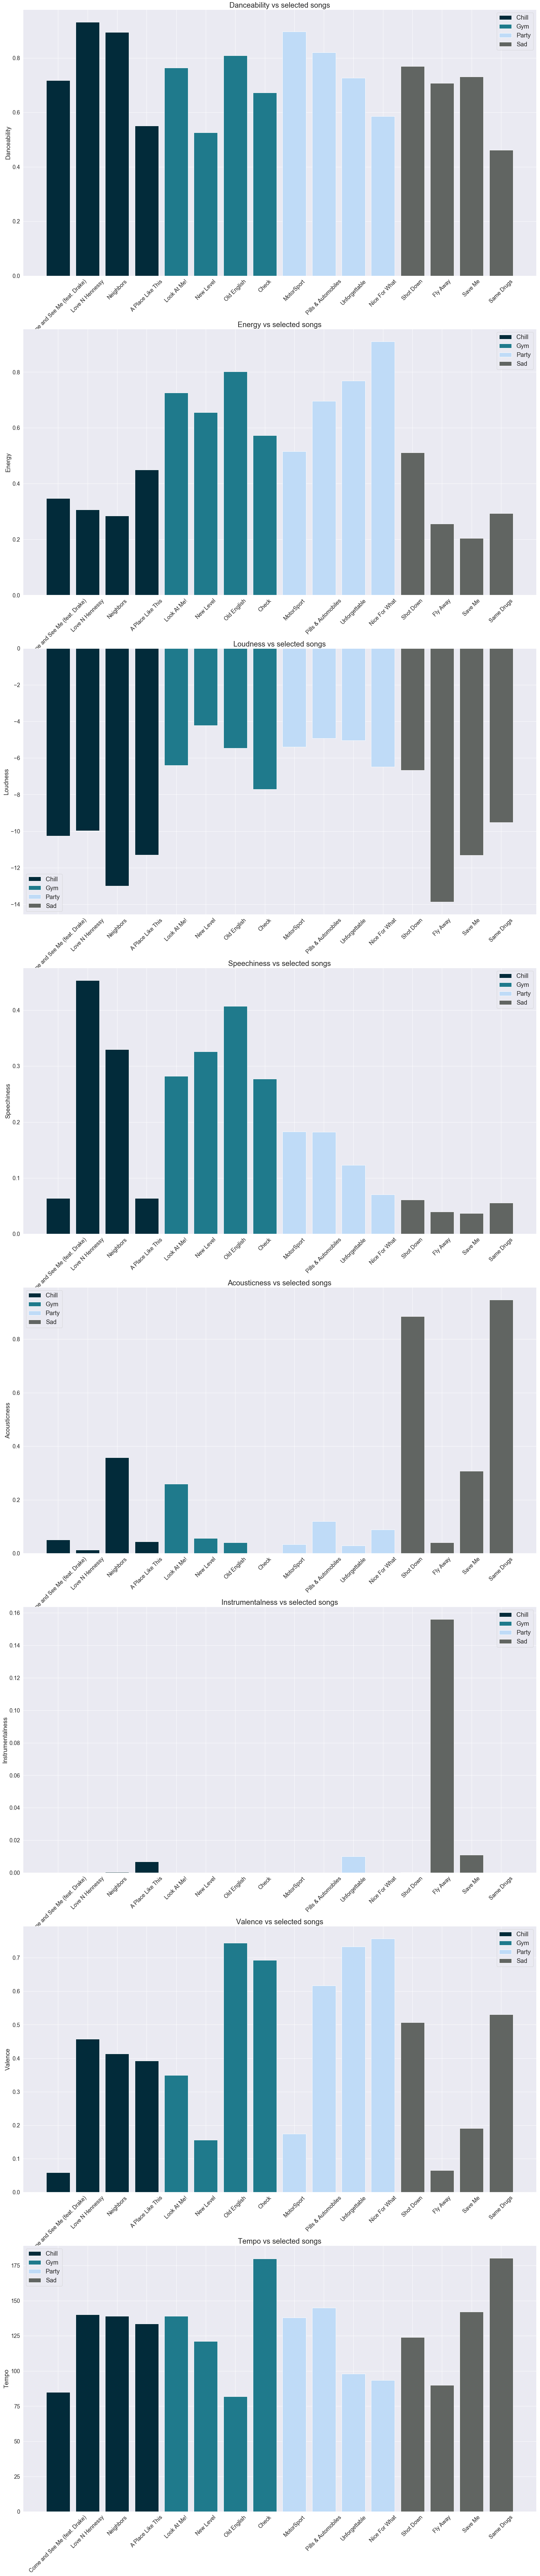

In [116]:
import numpy as np
import matplotlib.pyplot as plt
 
#display(all_lists)

plt.figure(figsize=(70,70))
a = (a1,a2,a3,a4,a5,a6,a7,a8)
f,a = plt.subplots(len(attributes),1,figsize=(30,150))
colors = {'Chill':'#022B3A', 'Gym':'#1F7A8C', 'Party':'#BFDBF7', 'Sad':'#616562'}


i = 0
for ax in a:
    for key,df in all_lists.groupby('type'):
        ax.bar(x=df['name'], height=df[attributes[i]], label=key, color=colors[key])
        ax.legend(fontsize=20)
        ax.set_title(attributes[i].capitalize() + ' vs selected songs', fontsize=24)
        ax.set_ylabel(attributes[i].capitalize(), fontsize=20)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(18)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(18)

    i+=1

plt.show()

## [Analysis of graphs]

## ML


In [123]:
from sklearn import tree



features = ['speechiness', 'energy', 'loudness', 'acousticness']

def get_ftr_array(uri):
    name = sp.track(uri)['name']
    anal = sp.audio_features(uri)[0]
    return np.array([anal[x] for x in features])


X = []
Y = []
for key, row in all_lists.iterrows():
        X.append(row[features].values)
        Y.append(row['type'])


clf = tree.DecisionTreeClassifier()
clf.fit(X,Y)

f = get_ftr_array('2cYqizR4lgvp4Qu6IQ3qGN').reshape(1, 4)

clf.predict(f)

array(['Party'], dtype='<U5')